
<img src="https://raw.githubusercontent.com/archivesunleashed/archivesunleashed.org/master/themes/hugo-material-docs/static/images/logo-square.png" height="100px" width="100px">


# Welcome

Welcome to the Archives Unleashed Cloud Visualization Demo in Jupyter Notebook for your collection. This demonstration takes the main derivatives from the Cloud and uses Python to analyze and produce information about your collection.

This product is in beta, so if you encounter any issues, please post an [issue in our Github repository](https://github.com/archivesunleashed/auk/issues) to let us know about any bugs you encountered or features you would like to see included.

If you have some basic Python coding experience, you can change the code we provided to suit your own needs.

Unfortunately, we cannot support code that you produced yourself. We recommend that you use `File > Make a Copy` first before changing the code in the repository. That way, you can always return to the basic visualizations we have offered here. Of course, you can also just re-download the Jupyter Notebook file from your Archives Unleashed Cloud account.

### How Jupyter Notebooks Work:

If you have no previous experience of Jupyter Notebooks, the most important thing to understand is that that <Shift><Enter/Return> will run the python code inside a window and output it to the site.
    
The window titled `# RUN THIS FIRST` should be the first place you go. This will import all the libraries and set basic variables (e.g. where your derivative files are located) for the notebook. After that, everything else should be able to run on its own.

If you just want to see the results for your collection, use `Cell > Run All`.


In [216]:
# Required imports from sys

from collections import Counter
import logging

coll_id = "4656"
auk_fp = "./data/"
auk_full_text = auk_fp + coll_id + "-fulltext.txt"
auk_gephi = auk_fp + coll_id + "-gephi.gexf"
auk_graphml = auk_fp + coll_id + "-gephi.grapml"
auk_domains = auk_fp + coll_id + "-fullurls.txt"
auk_filtered_text = auk_fp + coll_id + "-filtered_text.zip"

In [217]:
def sanity_check():
    output = "This script will check if you have all required dependencies:\n\n"
    try:
        import matplotlib.pyplot
        output += "Matplotlib OK.\n"
    except ImportError:
        output += "ERROR MATPLOTLIB required: Matplotlib is required to show graph visualizations.\n"
        output += "                           Try `pip install -u matplotlib` to install.\n"
    try:
        import numpy
        output += "Numpy OK.\n"
    except ImportError:
        output += "WARN NUMPY MISSING: You will not be able to use some math features.\n"
        output += "                    Try `pip install -u numpy` to install.\n"
    try:
        import pandas
        output += "Pandas OK.\n"
    except ImportError:
        output += "WARN PANDAS MISSING: This means you cannot access dataframes.\n"
        output += "                     Try `pip install -u pandas` to install.\n"
    try: 
        from nltk.tokenize import word_tokenize, sent_tokenize
        from nltk.draw.dispersion import dispersion_plot as dp
        nltk.download('vader_lexicon')
        output += "Nltk OK.\n"
    except ImportError:
        output += "WARN NLTK MISSING: This means you cannot do text analysis.\n"
        output += "                   Try `pip install -u nltk` to install.\n"
    try:
        open(auk_full_text)
        output += "Full text OK.\n"
    except NameError:
        output += "ERROR No File Variables: Looks like you forgot to run the first window.\n"
        output += "                         Use <SHIFT><RETURN/ENTER> on the first code window\n"
    except FileNotFoundError:
        output += "ERROR No File Access: Could not open the full-text file.\n"
        output += "                      Did you remember to include the downloads in the same folder?\n"
    try:
        open(auk_gephi)
        output += "Gephi OK.\n"
    except NameError:
        output += "ERROR No File Variables: Looks like you forgot to run the first window.\n"
        output += "                         Use <SHIFT><RETURN/ENTER> on the first code window\n"
    except FileNotFoundError:
        output += "ERROR No File Access: Could not open the gephi file.\n"
        output += "                      Did you remember to include the downloads in the same folder?\n"
    try:
        open(auk_domains)
        output += "Domains OK.\n"
    except NameError:
        output += "ERROR No File Variables: Looks like you forgot to run the first window.\n"
        output += "                         Use <SHIFT><RETURN/ENTER> on the first code window\n"
    except FileNotFoundError:
        output += "ERROR No File Access: Could not open the domains file.\n"
        output += "                      Did you remember to include the downloads in the same folder?\n"
    return (output)

print(sanity_check())
    
    

This script will check if you have all required dependencies:

Matplotlib OK.
Numpy OK.
Pandas OK.
Nltk OK.
Full text OK.
Gephi OK.
Domains OK.



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ryandeschamps/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Text Analysis

The following set of functions use the [Natural Language Toolkit](https://www.nltk.org) Python library to search for the top most used words in the collection, as well as facilitate breaking it down by name or domain.

Set the variables below if you wish to make some changes.

In [218]:
##  CONSTANTS / CONFIGURATION
#
# If you wish to fine tune the outputs, you may change the following:
#
# maximum number of words to show in output.
# Jupyter will create an output error if the number is too high.
TOP_COUNT = 30 

# Domain suffixes to check non-U.S. domains.
# so that (e.g.) www.google.co.uk will become "google"
STOP_DOMAINS = ["co", "org", "net", "edu"] # domain suffixes to remove

# minimum number of characters for a word to be included in a corpus
MINIMUM_WORD_LENGTH = 3 # eliminates "it", "I", "be" etc.

# list of substrings to filter a text line, if desired
LINE_FILTER = ['404 Not Found']


## Toolkit imports
import matplotlib.pyplot as pp
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.draw.dispersion import dispersion_plot as dp
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def clean_domain(s):
    """Extracts the name from the domain (e.g. 'www.google.com' becomes 'google')."""
    ret = ""
    dom = s.split(".")
    if len(dom) <3: # x.com is always x
        ret = dom[0]
    elif dom[-2] in STOP_DOMAINS: # www.x.co.uk should be x
        ret = dom[-3]
    else:
        ret = dom[1]
    return ret


def get_text(by="all", minline=MINIMUM_WORD_LENGTH):
    """Get just the text from the files."""
    text = []
    with open(auk_full_text) as fin:
        for line in fin:
            split_line = str(line).split(",")
            if (len(split_line[3]) >= 3 and set([split_line[3].find(x) for x in LINE_FILTER]) == {-1}):   
                if by == "domain":    
                    text.append((clean_domain(split_line[1]), split_line[3]))
                elif by == "year":
                    text.append((split_line[0][1:5], split_line[3]))
                else:
                    text.append(split_line[3])
    return text

def get_text_tokens (minlen=MINIMUM_WORD_LENGTH) :
    """Get the data and tokenize the text."""
    tokens = []
    with open (auk_full_text) as fin:
        for line in fin:
            split_line = str(line).split(",")
            # remove lines that are smaller than 3 chars or in the FILTER list.
            if (len(split_line[3]) >= 3 and set([split_line[3].find(x) for x in LINE_FILTER]) == {-1}):
                tokens += word_tokenize(str(line).split(",")[3])
    tokens = [x for x in tokens if len(x) > minlen]
    return tokens

def get_tokens_domains(minlen=MINIMUM_WORD_LENGTH):
    """Get tokens by domain"""
    tokens = []
    with open (auk_full_text) as fin:
        for line in fin:
            split_line = str(line).split(',')
            if (len(split_line[3]) >= 3 and set([split_line[3].find(x) for x in LINE_FILTER]) == {-1}):
                tokens.append((clean_domain(split_line[1]), Counter([x for x in word_tokenize(str(split_line[3])) if len(x) > minlen])))
    return tokens

def get_tokens_years(minlen=MINIMUM_WORD_LENGTH):
    """Get tokens by year."""
    tokens = []
    with open (auk_full_text) as fin:
        for line in fin:
            split_line = str(line).split(',')
            if (len(split_line[3]) >= 3 and set([split_line[3].find(x) for x in LINE_FILTER]) == {-1}):
                tokens.append((split_line[0][1:5], Counter([x for x in word_tokenize(str(split_line[3])) if len(x) > minlen])))
    return tokens

def year(minlen=MINIMUM_WORD_LENGTH):
    """Used by get_top_tokens_by to get the tokens by year."""
    return get_tokens_years(minlen)

def domain(minlen=MINIMUM_WORD_LENGTH):
    """Used by get_top_tokens_by to get tokens by domain."""
    return get_tokens_domains(minlen)
 
def get_top_tokens(total=TOP_COUNT, minlen=MINIMUM_WORD_LENGTH):
    """Return the top tokens for the text."""
    return [(key, value) for key, value in Counter(get_text_tokens(minlen)).most_common(total)]

def get_top_tokens_by(fun, total=TOP_COUNT, minlen=MINIMUM_WORD_LENGTH):
    """ Get the top tokens by a function.
    
    Parameters
    ----------
    fun: A function that returns a list of (key, Counter([tokenized_list]))
    total: The number of top tokens to return for each key.
    minlen: The minimum word length.
    
    Returns
    -------
    ret: list of minlen tokens by fun.
    """
    
    sep = dict()
    tokens = fun(minlen)
    sep = {k[0]: Counter() for k in tokens}
    for key, value in tokens:
        sep[key] += value
    ret = [(key, val.most_common(total)) for key, val in sep.items()]
    return (ret)

# applies utf-16 encoding to text, if possible
def international(text):
    unicode = text.encode("utf-8")
    try:
        ret = unicode.decode("UTF-32-LE")
    except UnicodeDecodeError:
        try:
            ret = unicode.decode("UTF-32-BE")
        except UnicodeDecodeError:
            try: 
                ret = unicode.decode("UTF-16-LE")
            except UnicodeDecodeError:
                try: 
                    ret = unicode.decode("UTF-16-BE")
                except UnicodeDecodeError:
                    logging.warning("Could not convert text to UTF-16 or UTF-32. Restoring UTF-8")
                    ret = unicode.decode("UTF-8")
            
    return ret

# writes results to stdout
def write_output (stdout, results):
    try:
        with open(filename, "w") as output:
            for value in results:
                output_file_write(str(value))
    except:
        print("Error writing the file.")
        
def sentiment_scores(by="domain"):
    sep = dict()
    corpus = get_text(by)
    sep = {k[0]: [] for k in corpus}
    for key, value in corpus:
        sep[key] += sent_tokenize(value)
    sid = SentimentIntensityAnalyzer()
    result = []
    for a, b in sep.items():
        scores = Counter({"neg": 0, "pos":0, "neu":0, "compound":0})
        for c in b:
            scores.update(sid.polarity_scores(c))
        result += [(a, ("neg", scores['neg']/len(b)), ("pos", scores['neg']/len(b)), ("neu", scores['neu']/len(b)), ("compound", scores['compound']/len(b)))]
      #  [(key, sid.polarity_scores(text)) for key, text in sep.items()]
    return(result)

Now that you have saved the above functions, you can now use them in a variety of ways. 

### Text by Year

In [219]:
method = "year" # choose "year", "domain" or "all"

# Get the set of available years in the collection 
year_range = set([x[0] for x in get_text(method)])
print(year_range)

{'2016', '2009', '2014'}


Now we can create separate lists with text files from individual years in this collection. You can add years (e.g. "2019") to `filtered_range` to limit your results.

In [220]:
# change if you want a different filename.
OUTPUT_FILENAME = "./filtered_text.txt" # filename if you want to output to another file.

# The years to include in the analysis. If empty, you will get all available years.
FILTERED_YEARS = [] # e.g. ['2015', '2016', '2019']

year_filter = FILTERED_YEARS if FILTERED_YEARS else year_range # add or remove years for filter
year_results = [t[1] for t in get_text("year") if t[0] in list(year_filter)]
    
# Some of the text may be in an international font.
for i in year_results[:10]:
    print(international(i))

## Commenting out the following will write the results to a `output_filename

#write_output(output_filename, year_results)

慎慮浩⁯慄汩⁹敎獷ⴠ丠湡楡潭䐠楡祬丠睥⁳敒污䔠瑳瑡⁥ⵥ摅瑩潩⁮扏瑩⁳㜲냂匠湵祮䠠浯⁥畏⁲敔浡䌠湯慴瑣唠⁳摁敶瑲獩湩⁧湉潦丠睥⁳䍂丠睥⁳灓牯獴䈠⁃灓牯獴䈠⁃慇敭⁳䙎⁌畂楳敮獳䈠⁃畂楳敮獳䔠瑮牥慴湩敭瑮䈠⁃牁獴☠䔠瑮牥慴湩敭瑮圠慨❴⁳湯䜠極敤传牵吠睯⁮灏湩潩⁮䍂传楰楮湯⁳敌瑴牥⁳敗⁢潐汬䐠楲敶慷⁹潗汲⁤慃慮慤⼠圠牯摬匠潰瑲⁳慖据畯敶⁲ꃂ䌠慬獳晩敩獤䈠潲獷⁥汃獡楳楦摥⁳䍂䨠扯⁳潃湮捥⁴楷桴唠⁳ꃂ䜠潯扤敹瀠獯整⁤慊⁮㤲
봈   ϯ뾽絫匣㧯뾽뵧♢뷯뾽봽뷯뾽ὥᯯ뾽䟯뾽㹀䌏珯뾽湎䏯뾽뷯뾽봠䉕◯뾽햔뵪䩕뷯뾽봣뵧봓燯뾽뵟爳◯뾽봯⃯뾽힬봙뵒뷯뾽䳯뾽㋯뾽哯뾽뷯뾽뵾봿뷯뾽봁뷯뾽뷯뾽ㄹ뷯뾽睼뵏狯뾽勯뾽뷯뾽绯뾽뷯뾽뷯뾽倫봵狯뾽可뾽寯뾽봺봮봎㻯뾽䣯뾽ἄ廯뾽哯뾽뷯뾽⩞嗯뾽뷯뾽⯯뾽紪뷯뾽뵝⯙껯뾽姯뾽⃯뾽뷎齾磯뾽槯뾽穠㯯뾽㏯뾽뷯뾽氶䯗頧✳뷯뾽廯뾽뷯뾽积뾽ī㧯뾽嗯뾽뷯뾽뵿
Nanaimo Daily News - Local News
Whidbey News-Times - Google+ Search Images Maps Play YouTube News Gmail Drive More Calendar Translate Mobile Books Wallet Shopping Blogger Finance Photos Videos Docs Even more » Account Options Sign in Help Send Feedback Web History Profile Home Profile People Collections Communities Events Hangouts Pages Settings Feedback Help  ·  Region Privacy  ·  Terms  ·  Maps Terms Start a hangout Whidbey News-Times 34 followers|212
慆散潢歯䌠潲獳䐭浯楡⁮敍獳条湩⁧敨灬牥匠䍅剕呉⁙䅗乒义㩇倠敬獡⁥牴慥⁴桴⁥剕⁌扡癯⁥獡礠畯眠畯摬礠畯⁲慰獳潷摲愠摮搠⁯潮⁴桳牡⁥瑩眠瑩⁨湡潹敮‮敓⁥桴⁥慆散潢歯䠠汥⁰敃瑮牥映牯洠牯⁥湩潦浲瑡潩⹮਩
SafeFrame Container)

뿯ࢽ   

### Text by Domain

In [221]:
# Get the set of available domains in the collection 
domain_set = set([x[0] for x in get_text("domain")])
print(domain_set)

{'accuweather', 'issuu', 'schema', 'googleapis', 'save', 'nanaimodailynews', 'blackpress', 'googlesyndication', 'facebook', 'google'}


In [222]:
# extract only the given domain to a file and see how many results there are
filtered_domains = [] # e.g ["google", "apple", "facebook"]
domain_set = filtered_domains if filtered_domains else domain_set
domain_results = [t[1] for t in get_text("domain") if t[0] in domain_set]
print("****Total files****:" + str(len(domain_results)) + "\n")
print("****Sample results****: \n")
for samp in domain_results[:10]:
    if len(samp) > 4:
        print(international(samp) + " \n")

****Total files****:9987

****Sample results****: 

慎慮浩⁯慄汩⁹敎獷ⴠ丠湡楡潭䐠楡祬丠睥⁳敒污䔠瑳瑡⁥ⵥ摅瑩潩⁮扏瑩⁳㜲냂匠湵祮䠠浯⁥畏⁲敔浡䌠湯慴瑣唠⁳摁敶瑲獩湩⁧湉潦丠睥⁳䍂丠睥⁳灓牯獴䈠⁃灓牯獴䈠⁃慇敭⁳䙎⁌畂楳敮獳䈠⁃畂楳敮獳䔠瑮牥慴湩敭瑮䈠⁃牁獴☠䔠瑮牥慴湩敭瑮圠慨❴⁳湯䜠極敤传牵吠睯⁮灏湩潩⁮䍂传楰楮湯⁳敌瑴牥⁳敗⁢潐汬䐠楲敶慷⁹潗汲⁤慃慮慤⼠圠牯摬匠潰瑲⁳慖据畯敶⁲ꃂ䌠慬獳晩敩獤䈠潲獷⁥汃獡楳楦摥⁳䍂䨠扯⁳潃湮捥⁴楷桴唠⁳ꃂ䜠潯扤敹瀠獯整⁤慊⁮㤲 

봈   ϯ뾽絫匣㧯뾽뵧♢뷯뾽봽뷯뾽ὥᯯ뾽䟯뾽㹀䌏珯뾽湎䏯뾽뷯뾽봠䉕◯뾽햔뵪䩕뷯뾽봣뵧봓燯뾽뵟爳◯뾽봯⃯뾽힬봙뵒뷯뾽䳯뾽㋯뾽哯뾽뷯뾽뵾봿뷯뾽봁뷯뾽뷯뾽ㄹ뷯뾽睼뵏狯뾽勯뾽뷯뾽绯뾽뷯뾽뷯뾽倫봵狯뾽可뾽寯뾽봺봮봎㻯뾽䣯뾽ἄ廯뾽哯뾽뷯뾽⩞嗯뾽뷯뾽⯯뾽紪뷯뾽뵝⯙껯뾽姯뾽⃯뾽뷎齾磯뾽槯뾽穠㯯뾽㏯뾽뷯뾽氶䯗頧✳뷯뾽廯뾽뷯뾽积뾽ī㧯뾽嗯뾽뷯뾽뵿 

Nanaimo Daily News - Local News 

Whidbey News-Times - Google+ Search Images Maps Play YouTube News Gmail Drive More Calendar Translate Mobile Books Wallet Shopping Blogger Finance Photos Videos Docs Even more » Account Options Sign in Help Send Feedback Web History Profile Home Profile People Collections Communities Events Hangouts Pages Settings Feedback Help  ·  Region Privacy  ·  Terms  ·  Maps Terms Start a hangout Whidbey News-Times 34 followers|212 

慆散潢歯䌠潲獳䐭浯楡⁮敍獳条湩⁧敨灬牥匠䍅剕呉⁙䅗乒义㩇倠敬獡⁥牴慥⁴桴⁥剕⁌扡癯⁥獡礠畯眠畯摬礠畯⁲慰獳潷摲愠摮搠⁯潮⁴桳牡⁥瑩眠

## Overall Collection Characteristics

In [223]:
# Get a list of the top words in the collection
# (regardless of year).
get_top_tokens()

[('News', 32997),
 ('Sports', 26951),
 ('World', 17705),
 ('Business', 17512),
 ('Entertainment', 17502),
 ('Classifieds', 14711),
 ('Nanaimo', 13550),
 ('Daily', 13214),
 ('Canada', 9245),
 ('Games', 8830),
 ('Vancouver', 8824),
 ('Team', 8795),
 ('Home', 8785),
 ('Letters', 8779),
 ('Contact', 8777),
 ('Jobs', 8771),
 ('Advertising', 8769),
 ('Info', 8766),
 ('Opinion', 8764),
 ('Browse', 8758),
 ('Opinions', 8755),
 ('Poll', 8753),
 ('Guide', 8740),
 ('Town', 8710),
 ('What', 8695),
 ('Arts', 8692),
 ('Driveway', 8686),
 ('Obits', 8676),
 ('with', 6915),
 ('Real', 6070)]

In [224]:
# Get a list of the top tokens, separated by year.
get_top_tokens_by(year)

[('2009',
  [('News', 6),
   ('Nanaimo', 3),
   ('Daily', 3),
   ('Sports', 3),
   ('Business', 2),
   ('Entertainment', 2),
   ('World', 2),
   ('Classifieds', 2),
   ('Real', 1),
   ('Estate', 1),
   ('e-Edition', 1),
   ('Obits', 1),
   ('Sunny', 1),
   ('Home', 1),
   ('Team', 1),
   ('Contact', 1),
   ('Advertising', 1),
   ('Info', 1),
   ('Games', 1),
   ('Arts', 1),
   ('What', 1),
   ('Guide', 1),
   ('Town', 1),
   ('Opinion', 1),
   ('Opinions', 1),
   ('Letters', 1),
   ('Poll', 1),
   ('Driveway', 1),
   ('Canada', 1),
   ('Vancouver', 1)]),
 ('2016',
  [('News', 32990),
   ('Sports', 26948),
   ('World', 17703),
   ('Business', 17510),
   ('Entertainment', 17500),
   ('Classifieds', 14709),
   ('Nanaimo', 13547),
   ('Daily', 13211),
   ('Canada', 9244),
   ('Games', 8829),
   ('Vancouver', 8823),
   ('Team', 8794),
   ('Home', 8782),
   ('Letters', 8778),
   ('Contact', 8776),
   ('Jobs', 8770),
   ('Advertising', 8768),
   ('Info', 8765),
   ('Opinion', 8763),
   ('Brow

In [226]:
# Get a list of top tokens, separated by domain.
get_top_tokens_by(domain)

[('nanaimodailynews',
  [('News', 32906),
   ('Sports', 26951),
   ('World', 17705),
   ('Business', 17512),
   ('Entertainment', 17502),
   ('Classifieds', 14711),
   ('Nanaimo', 13461),
   ('Daily', 13125),
   ('Canada', 9244),
   ('Games', 8830),
   ('Vancouver', 8823),
   ('Team', 8794),
   ('Letters', 8779),
   ('Home', 8777),
   ('Contact', 8776),
   ('Jobs', 8771),
   ('Advertising', 8768),
   ('Info', 8764),
   ('Opinion', 8764),
   ('Browse', 8758),
   ('Opinions', 8755),
   ('Poll', 8753),
   ('Guide', 8740),
   ('Town', 8710),
   ('What', 8695),
   ('Arts', 8692),
   ('Driveway', 8686),
   ('Obits', 8676),
   ('with', 6914),
   ('Real', 6070)]),
 ('google',
  [('Whidbey', 2),
   ('News-Times', 2),
   ('Maps', 2),
   ('Help', 2),
   ('Feedback', 2),
   ('Profile', 2),
   ('Terms', 2),
   ('Google+', 1),
   ('Search', 1),
   ('Images', 1),
   ('Play', 1),
   ('YouTube', 1),
   ('News', 1),
   ('Gmail', 1),
   ('Drive', 1),
   ('More', 1),
   ('Calendar', 1),
   ('Translate', 1

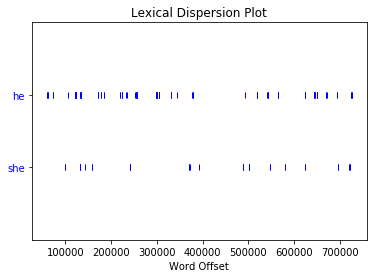

In [227]:
# Create a dispersion plot, showing where the list of words appear
# in the text.
text = get_text_tokens(1)
dp(text, ["he", "she"]) # uses the nltk dispersion plot library (dp).

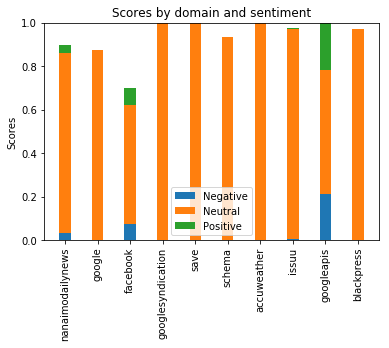

In [228]:
# Collect sentiment scores by domain and visualize them.

sent = sentiment_scores()
N = len(sent)
neg = [x[1][1] for x in sent]
pos = [x[2][1] for x in sent]
neu = [x[3][1] for x in sent]
labs = [x[0] for x in sent]

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = pp.bar(ind, neg, width)
p2 = pp.bar(ind, neu, width,
             bottom=neg)
p3 = pp.bar(ind, pos, width, bottom=neu)

pp.ylabel('Scores')
pp.title('Scores by domain and sentiment')
pp.xticks(ind, labs, rotation='vertical')
pp.legend((p1[0], p2[0], p3[0]), ('Negative', 'Neutral', 'Positive'))

pp.show()


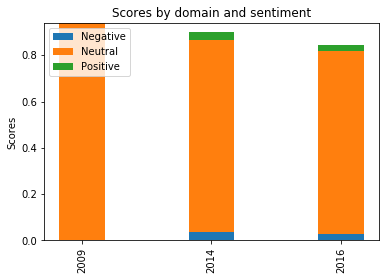

In [232]:
# Collect sentiment scores by year and visualize them.

sent = sentiment_scores("year")
N = len(sent)
neg = [x[1][1] for x in sent]
pos = [x[2][1] for x in sent]
neu = [x[3][1] for x in sent]
labs = sorted([x[0] for x in sent])

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = pp.bar(ind, neg, width)
p2 = pp.bar(ind, neu, width,
             bottom=neg)
p3 = pp.bar(ind, pos, width, bottom=neu)

pp.ylabel('Scores')
pp.title('Scores by domain and sentiment')
pp.xticks(ind, labs, rotation='vertical')
pp.legend((p1[0], p2[0], p3[0]), ('Negative', 'Neutral', 'Positive'))

pp.show()

# Bibliography

Bird, Steven, Edward Loper and Ewan Klein (2009), *Natural Language       Processing with Python*. O’Reilly Media Inc.

Archives Unleashed Project. (2018). Archives Unleashed Toolkit (Version 0.17.0). Apache License, Version 2.0.